In [1]:
from zodiax.experimental import deserialise
import amigo
from amgio import build_model
import jax
from jax import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps

import ehtplot
import scienceplots

plt.style.use(['science', 'bright', 'no-latex'])

# matplotlib parameters
%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.size"] = 8

inferno = colormaps["inferno"]
viridis = colormaps["viridis"]
seismic = colormaps["seismic"]

inferno.set_bad("k", 0.5)
viridis.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)

jax.config.update("jax_enable_x64", True)

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-063 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-065
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


dLux: Jax is running in 32-bit, to enable 64-bit visit: https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision


In [14]:
final_params_dir = "/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/io_outputs/"
model_cache = "/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/arrays/"
data_cache = "/Users/mcha5804/JWST/ERS1373/calslope_18/"

# Bind file path, type and exposure type
file_fn = lambda **kwargs: amigo.files.get_files(
    data_cache,
    "calslope",
    EXP_TYPE="NIS_AMI",
    FILTER=["F480M", "F430M", "F380M"],
    **kwargs
)

all_files = file_fn()  # loading io and calibrator files

# selecting the IO files out from the calibrator
files = [file for file in all_files if file[0].header["TARGPROP"] == "IO"]

In [3]:
model, exposures = build_model.build_io_model(files, model_cache)

In [4]:
final_params = deserialise(final_params_dir + "final_params.zdx" + "L2_1.0000e-03/")
losses = np.load(final_params_dir + "losses.npy")
histories = deserialise(final_params_dir + "histories.zdx")

fit_params = [
    "positions",
    "fluxes",
    "log_distribution",
    "source_spectrum.coefficients",
]

model = model.set(fit_params, final_params)


In [6]:
from matplotlib.transforms import Affine2D
from matplotlib.colors import PowerNorm
from plotting import get_arcsec_extents, io_on_that_day
import dLux.utils as dlu


def plot_diffraction_limit(model, ax=None, OOP=False):
    effective_wl = np.dot(model.source_spectrum.wavelengths, model.source_spectrum.weights)
    diff_lim = dlu.rad2arcsec(effective_wl / model.optics.diameter)
    scale_length = diff_lim

    scale_bar_x = -0.7
    scale_bar_y = scale_bar_x
    fontdict = {
        "fontstyle": "normal",
        "color": "hotpink",
        "weight": "demi",
        "size": 7,
    }

    if OOP and ax is not None:
        ax.plot(
            [scale_bar_x, scale_bar_x + scale_length],
            [scale_bar_y, scale_bar_y],
            color="hotpink",
            linewidth=2,
        )
        ax.text(
            scale_bar_x + scale_length / 2 - 0.075,
            scale_bar_y + 0.03,
            r"$\lambda / D$",
            **fontdict,
        )
        return ax

    else:
        plt.plot(
            [scale_bar_x, scale_bar_x + scale_length],
            [scale_bar_y, scale_bar_y],
            color="hotpink",
            linewidth=2,
        )
        plt.text(
            scale_bar_x + scale_length / 2 - 0.046,
            scale_bar_y + 0.02,
            r"$\lambda / D$",
            color="hotpink",
            fontdict=font,
        )


def plot_io(
    ax,
    array,
    roll_angle_degrees: float = 0.0,
    pixel_scale: float = 0.0656 / 4,
    model=None,
    show_diff_lim: bool = True,
    cmap: str = "afmhot_10u",
    bg_color: str = "k",
    axis_labels: dict = {
        "xlabel": r"$\Delta$RA [arcsec]",
        "ylabel": r"$\Delta$DEC [arcsec]",
    },
    vmin: float = 0.0,
    vmax: float = None,
    power=0.5,
):
    rotation_transform = Affine2D().rotate_deg(
        roll_angle_degrees
    )  # Create a rotation transformation

    ax.set_facecolor(bg_color)  # Set the background colour to black
    ax.tick_params(direction="out")
    ax.set(
        xticks=[-0.5, 0, 0.5],
        yticks=[-0.5, 0, 0.5],
        **axis_labels,
        )  # Set the axis labels
    if model is not None:
        pixel_scale = model.psf_pixel_scale / model.optics.oversample
        if show_diff_lim:
            ax = plot_diffraction_limit(model, ax, OOP=True)
    im = ax.imshow(
        array,
        cmap=cmap,
        extent=get_arcsec_extents(pixel_scale, array.shape),
        norm=PowerNorm(power, vmin=vmin, vmax=vmax),
        aspect="equal",
    )

    trans_data = rotation_transform + ax.transData  # creating transformation
    im.set_transform(trans_data)  # applying transformation to image

    return im


def plot_io_with_ephemeris(
    ax, array, date, roll_angle_degrees=246.80584209034947, legend=False, **kwargs
):
    body = io_on_that_day(n_volc=None, date=date)

    plot_io(ax, array, roll_angle_degrees, show_diff_lim=True, **kwargs)

    body.plot_wireframe_angular(
        ax,
        add_title=False,
        label_poles=True,
        indicate_equator=True,
        indicate_prime_meridian=False,
        grid_interval=15,
        grid_lat_limit=75,
        aspect_adjustable="box",
        formatting={
            "limb": {
                "linestyle": "--",
                "linewidth": 0.8,
                "alpha": 0.8,
                "color": "white",
            },
            "grid": {
                "linestyle": "--",
                "linewidth": 0.5,
                "alpha": 0.8,
                "color": "white",
            },
            "equator": {"linewidth": 1, "color": "r", "label": "equator"},
            "terminator": {
                "linewidth": 1,
                "linestyle": "-",
                "color": "aqua",
                "alpha": 0.7,
                "label": "terminator",
            },
            "coordinate_of_interest_lonlat": {
                "color": "g",
                "marker": "^",
                "s": 50,
                "label": "volcano",
            },
            # 'limb_illuminated': {'color': 'b'},
        },
    )

    if legend:
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(
            by_label.values(),
            by_label.keys(),
            loc="upper left",
        )


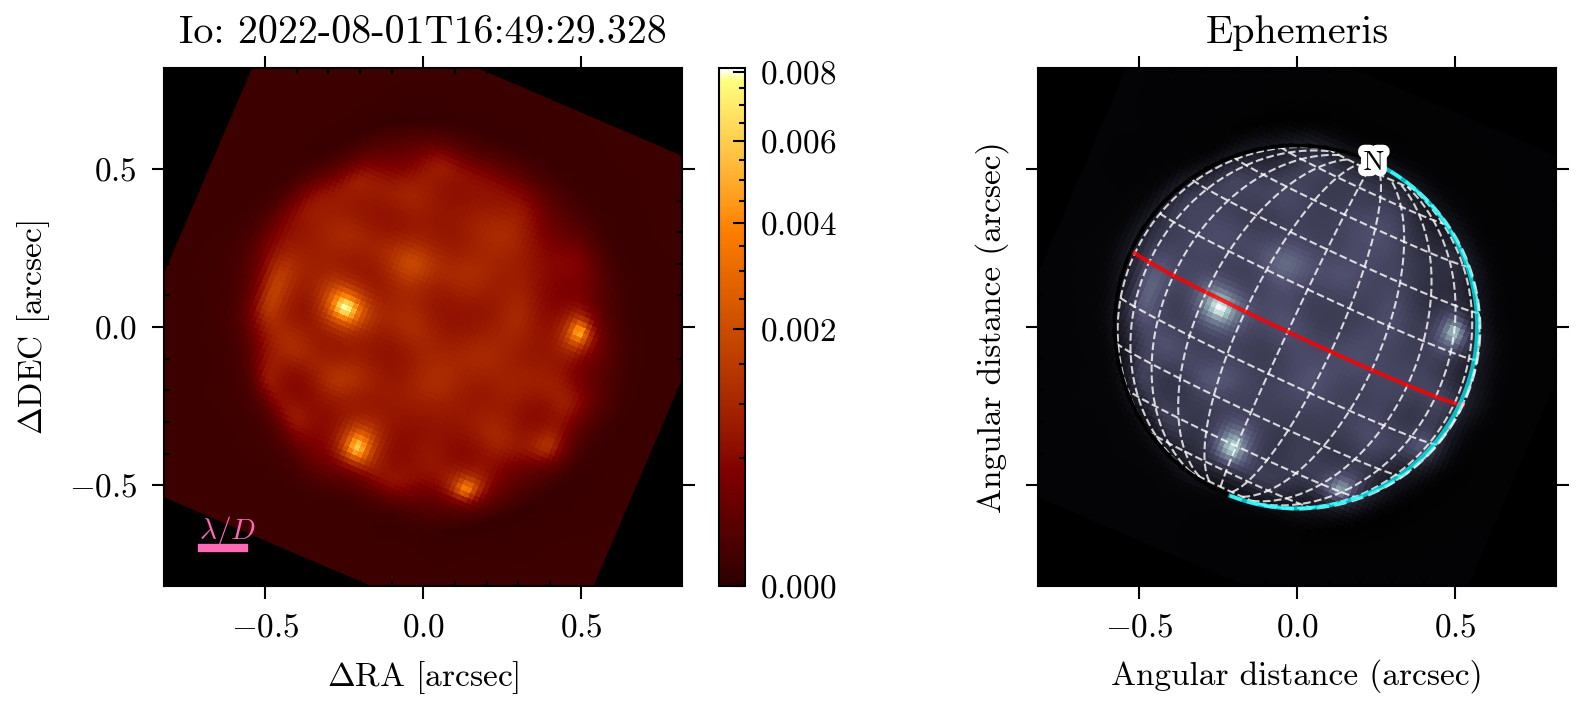

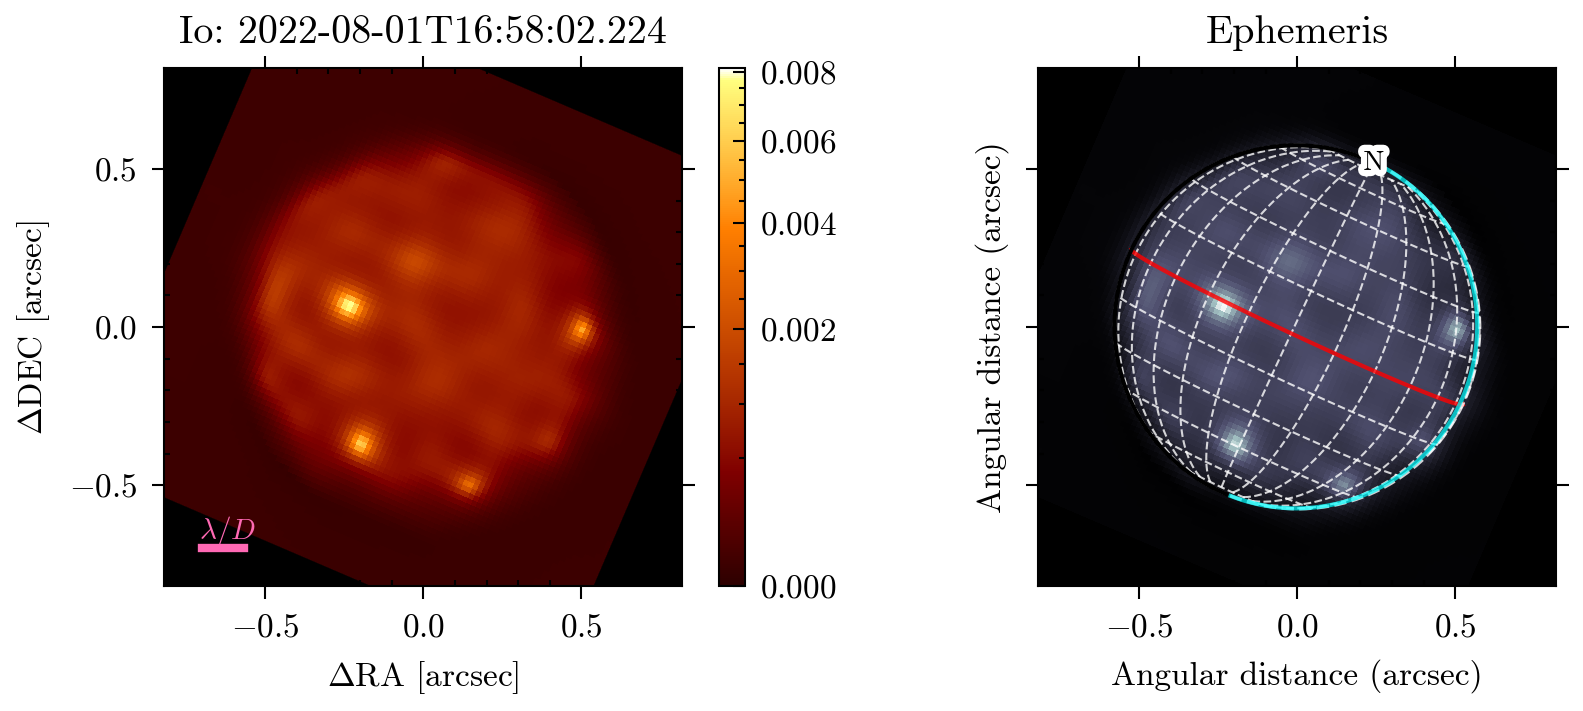

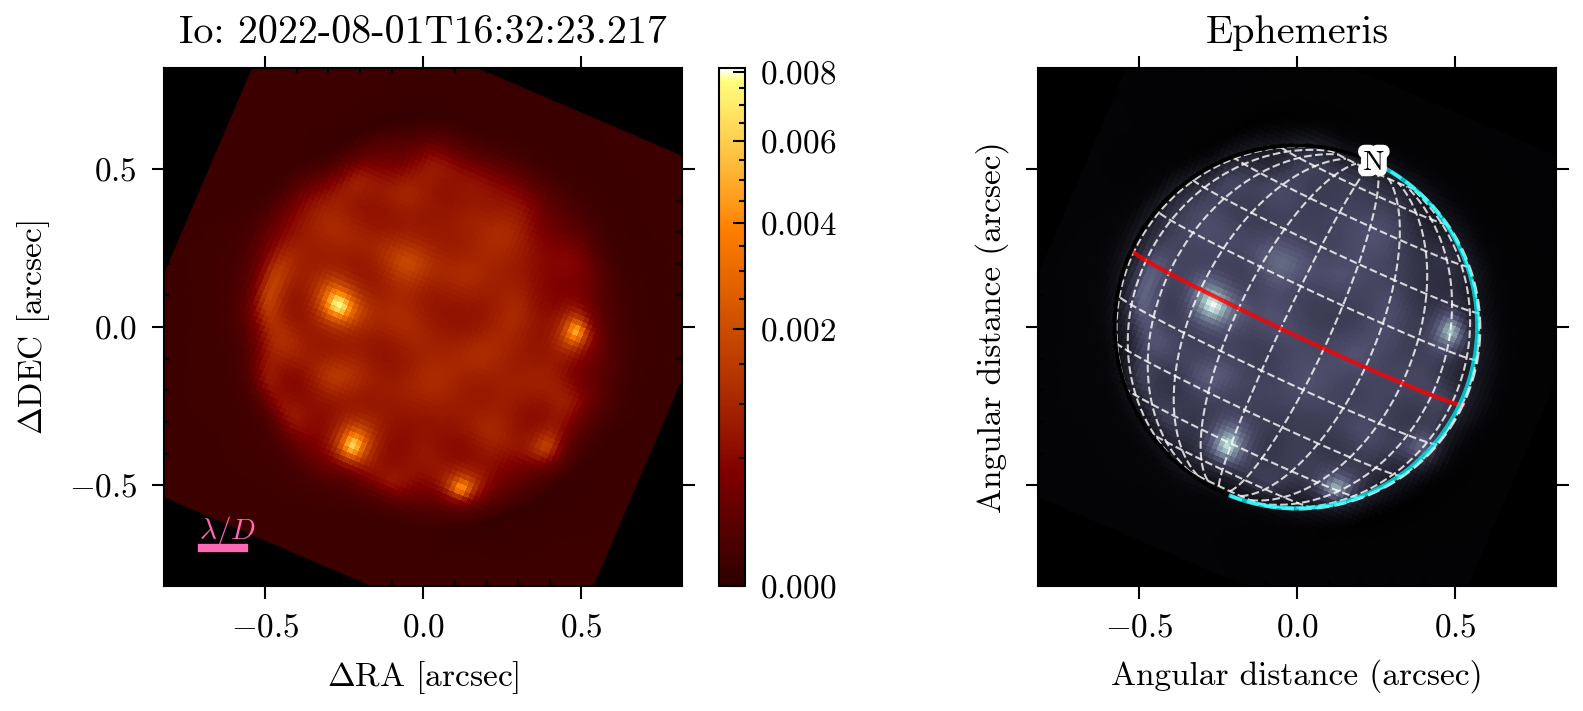

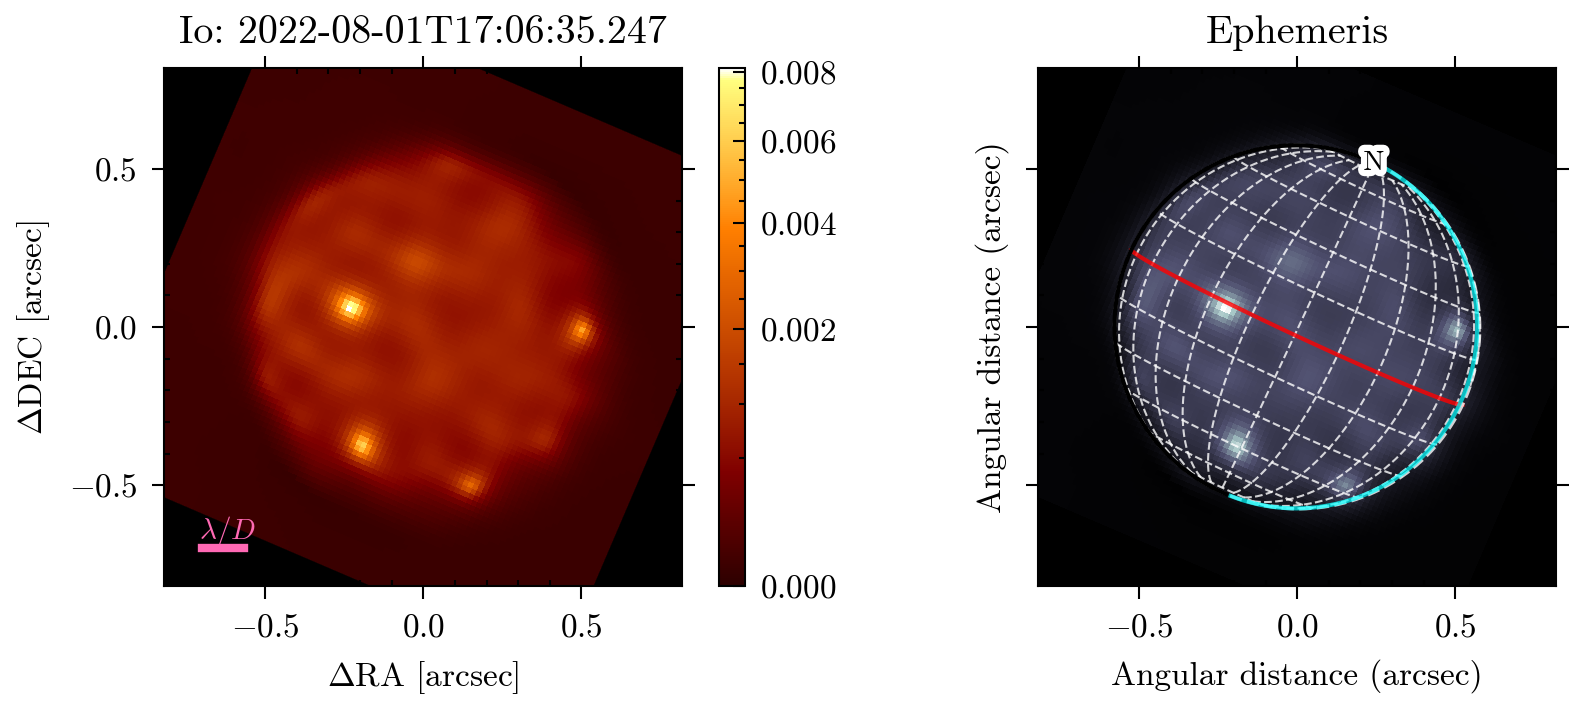

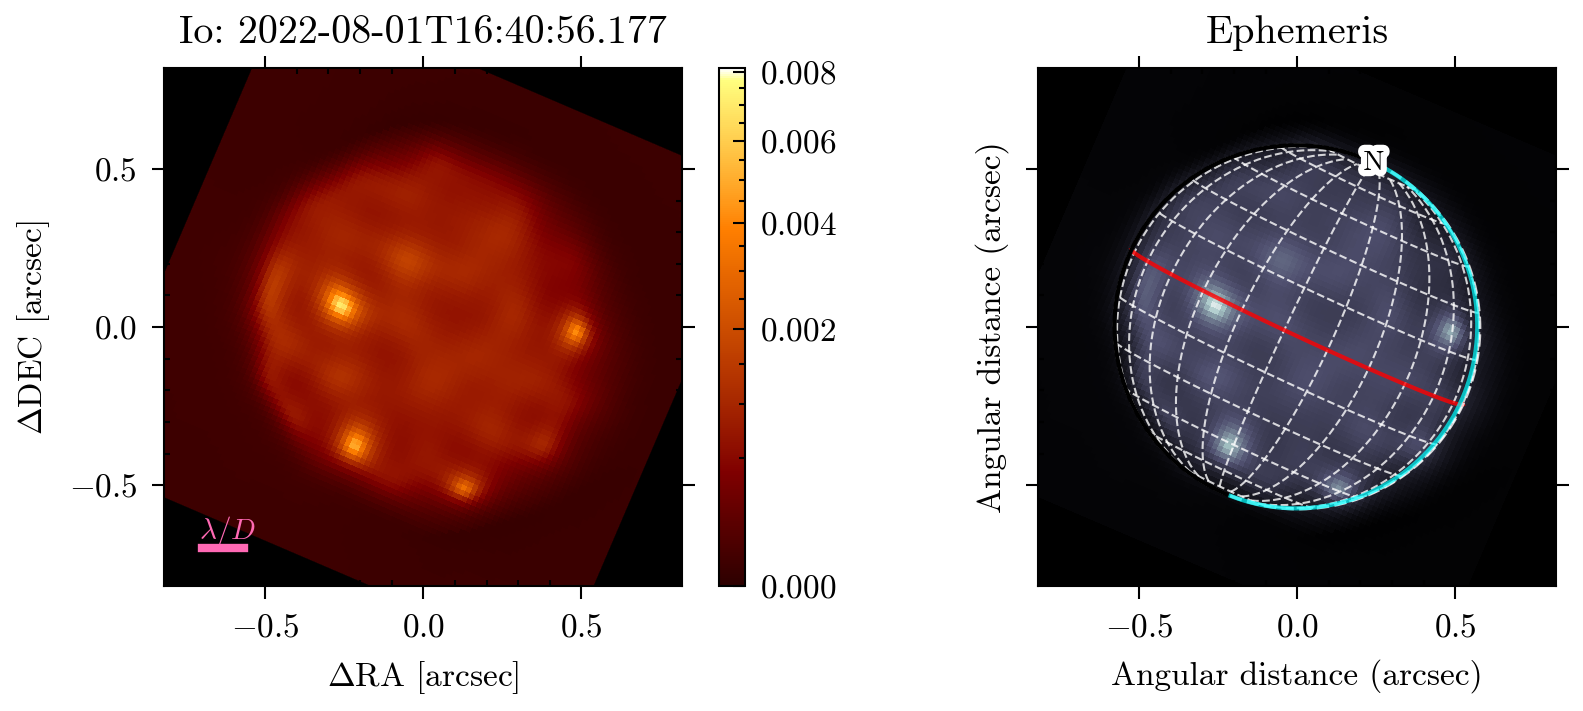

In [12]:
from io_funcs import niriss_parang

io_peak_flux = np.array(
        [10 ** model.log_distribution[exp.key] for exp in exposures]
    ).max()

save_dir = "gifs/spinning_io/"
for exp, file in zip(exposures, files):

    time = file[0].header["DATE-BEG"]
    roll_angle = niriss_parang(file[1].header)

    fig, ax = plt.subplots(1, 2, figsize=(6, 2.5), sharey=True)
    c0 = plot_io(
        ax[0],
        10 ** model.log_distribution[exp.key],
        roll_angle_degrees=roll_angle,
        model=model,
        cmap="afmhot_10u",
        vmax=io_peak_flux,
        show_diff_lim=True
        )
    
    c1 = plot_io_with_ephemeris(
        ax[1],
        10 ** model.log_distribution[exp.key],
        date=time,
        roll_angle_degrees=roll_angle,
        cmap="bone_u",
        vmax=io_peak_flux,
        axis_labels={"xlabel": "", "ylabel": ""},
    )

    fig.colorbar(c0)
    ax[0].set_title(f"Io: {time}")
    ax[1].set_title(f"Ephemeris")
    plt.tight_layout()
    # plt.savefig(save_dir + f"{time}.png", dpi=300)
    # plt.close()
    plt.show()


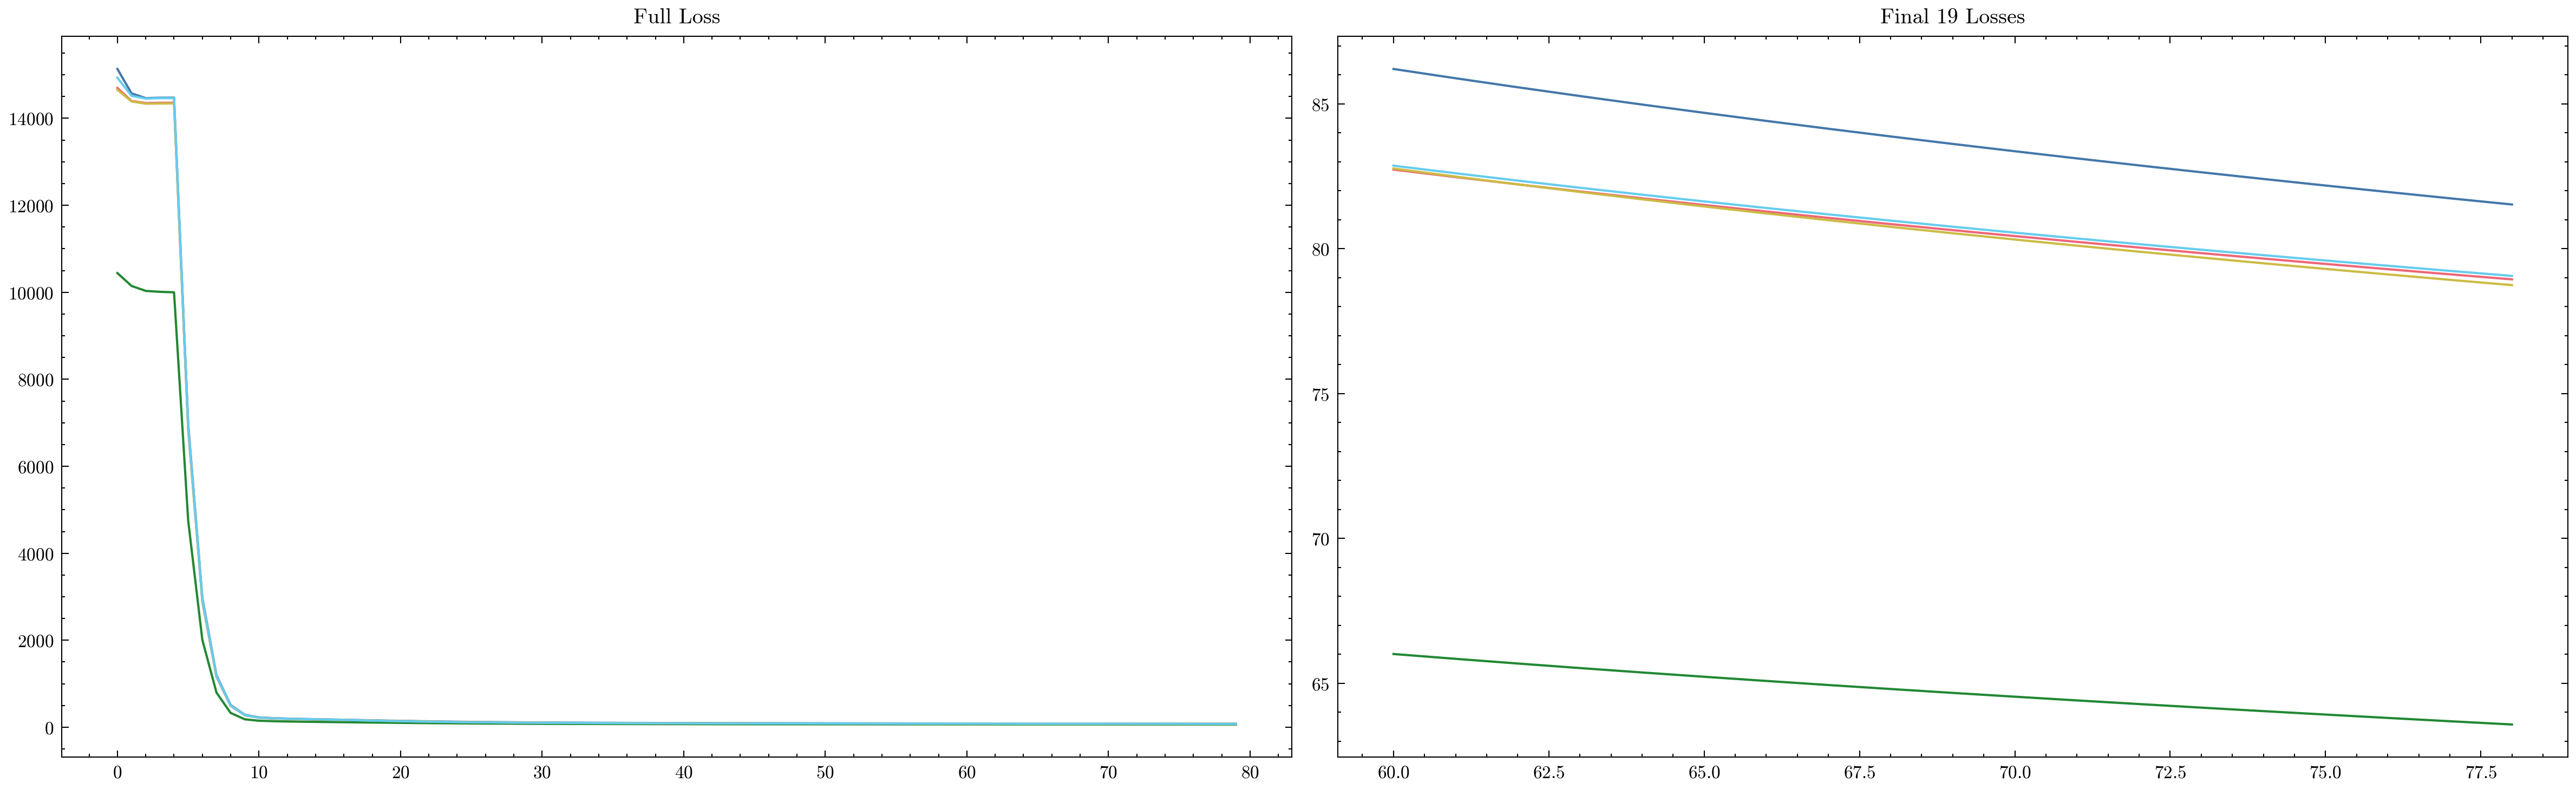

No formatting function for log_distribution
No formatting function for log_distribution
No formatting function for log_distribution
No formatting function for log_distribution
No formatting function for log_distribution


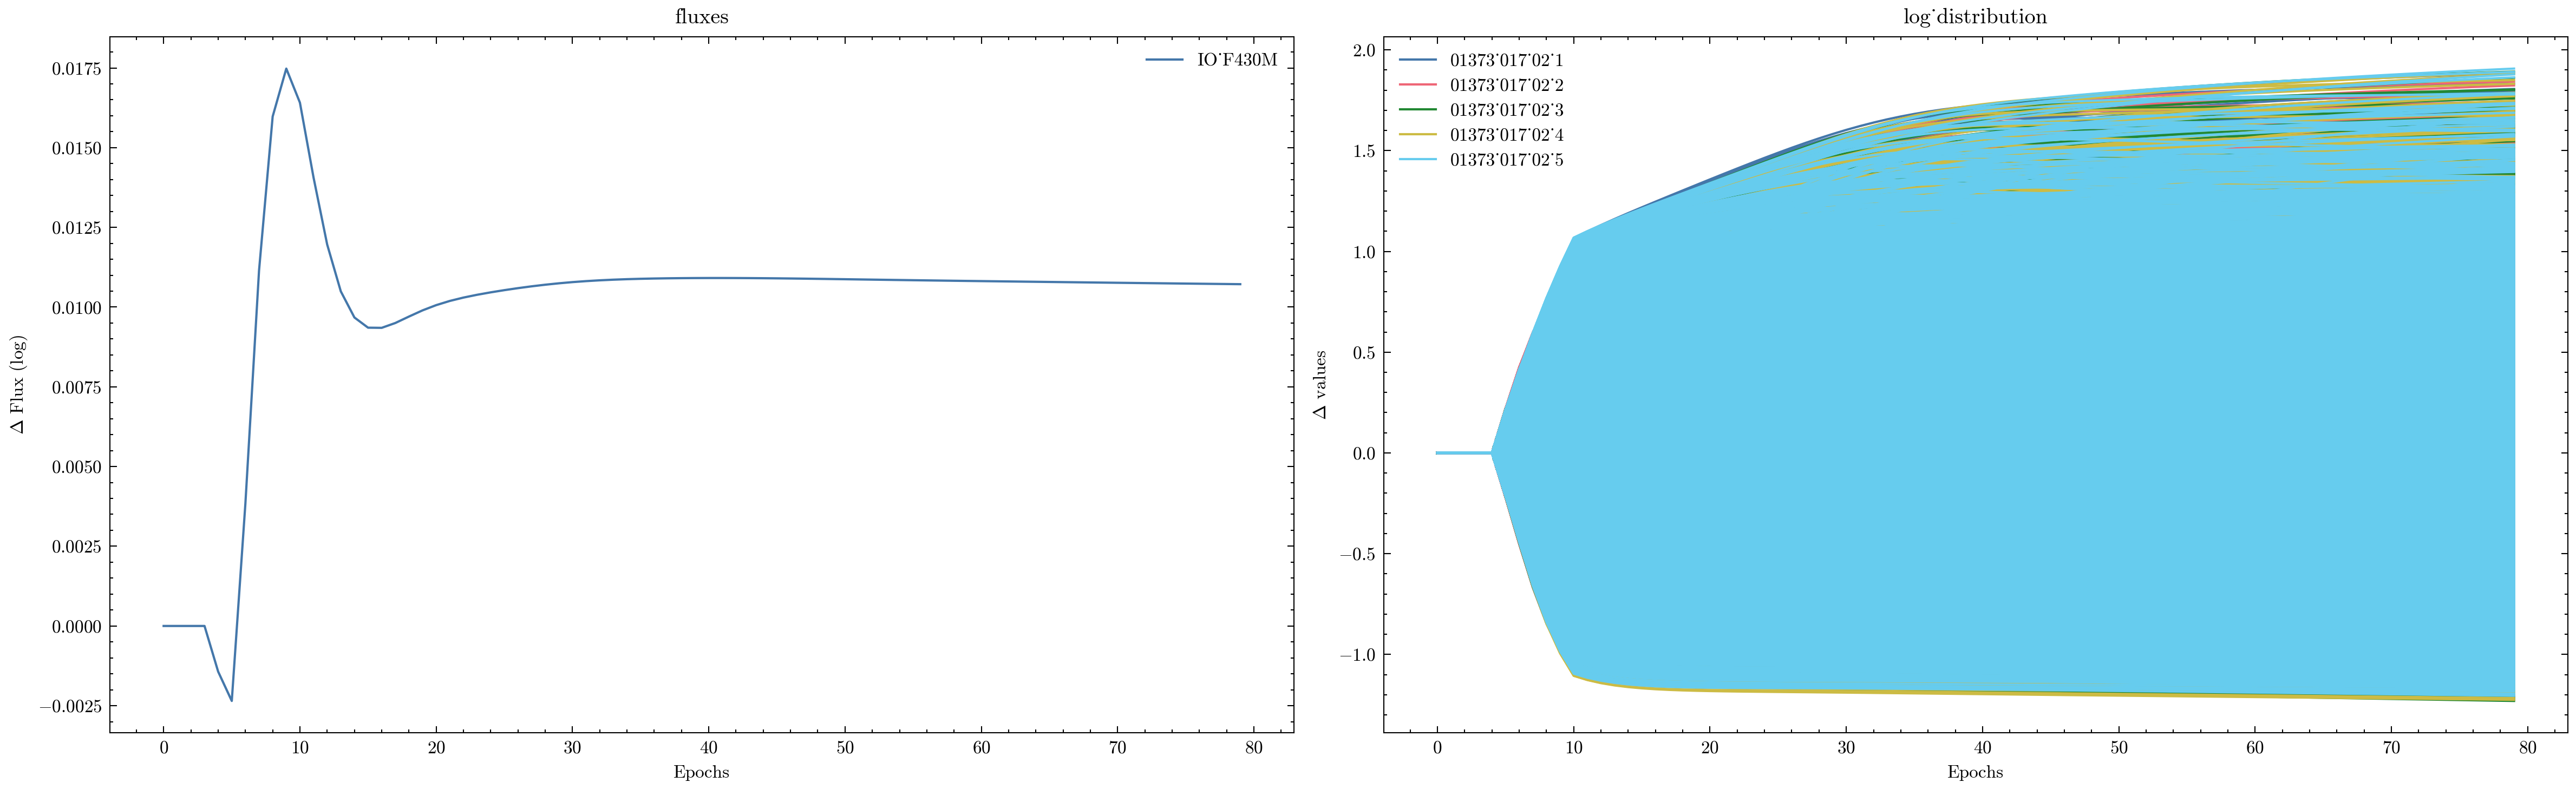

No formatting function for source_spectrum.coefficients


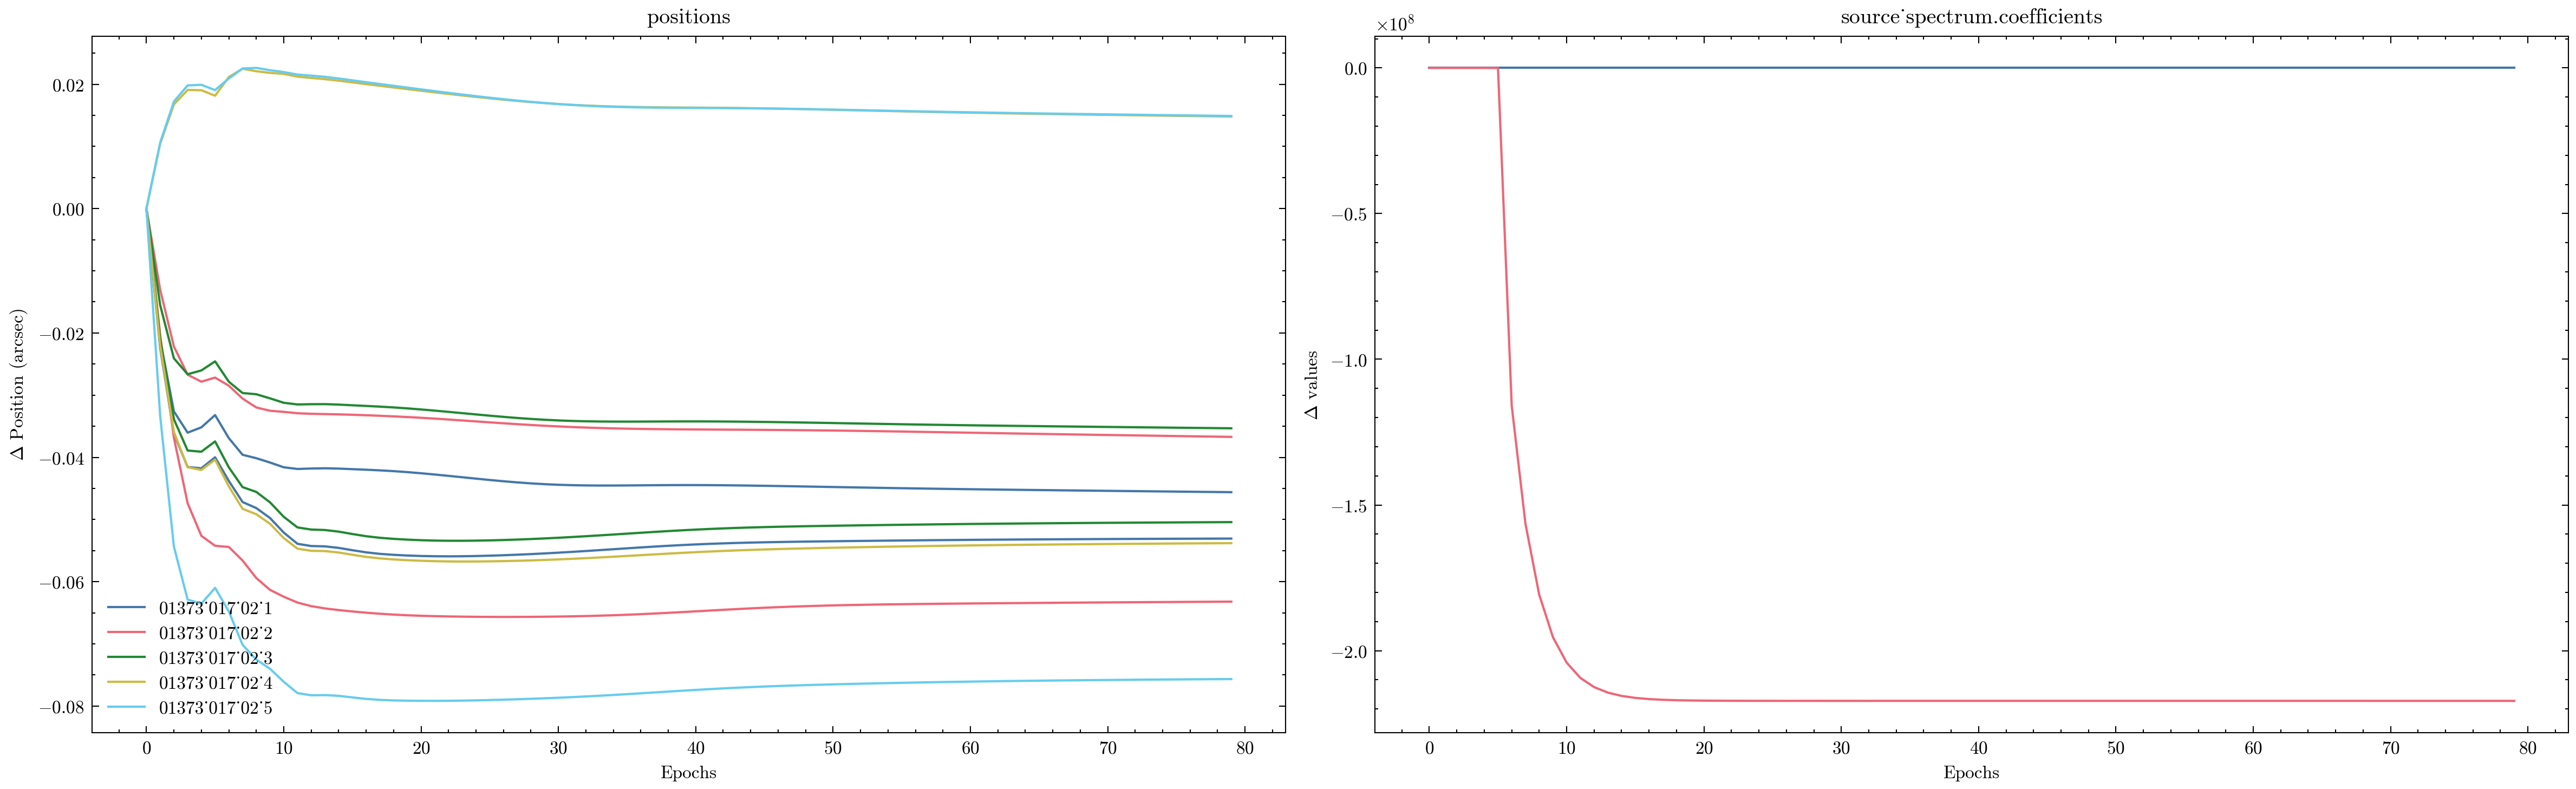

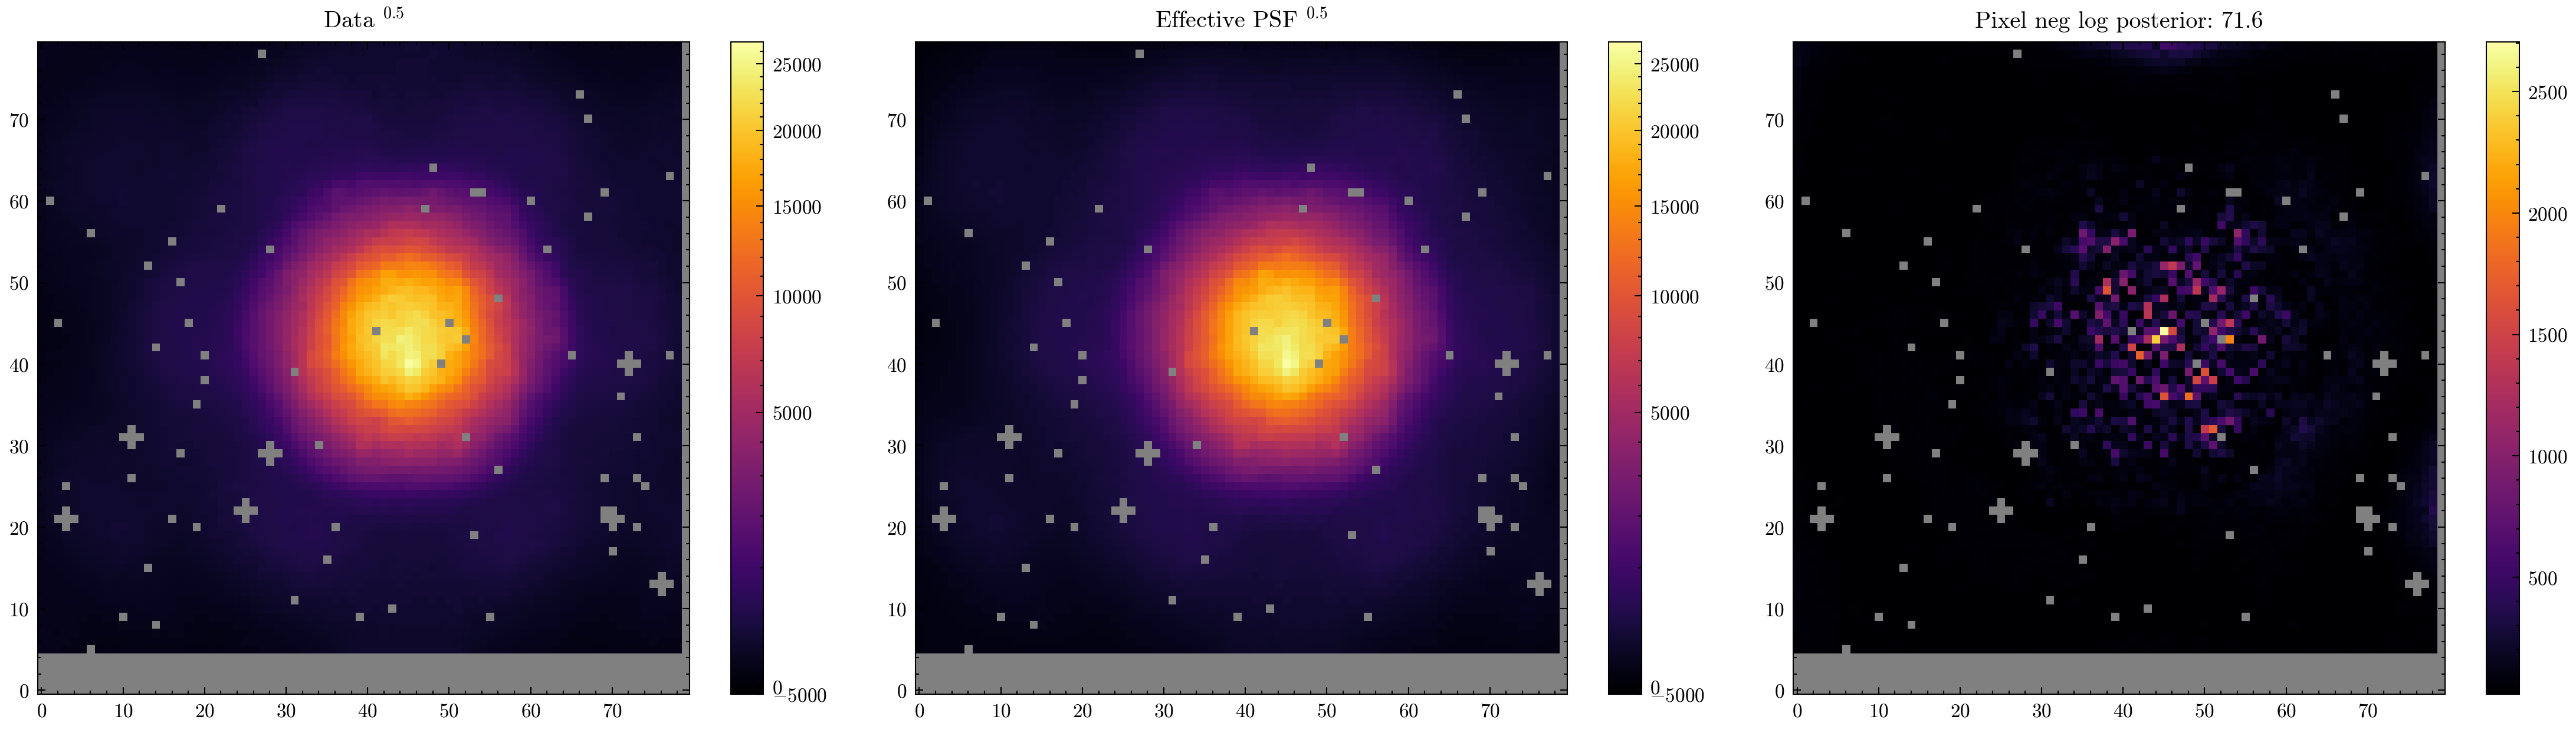

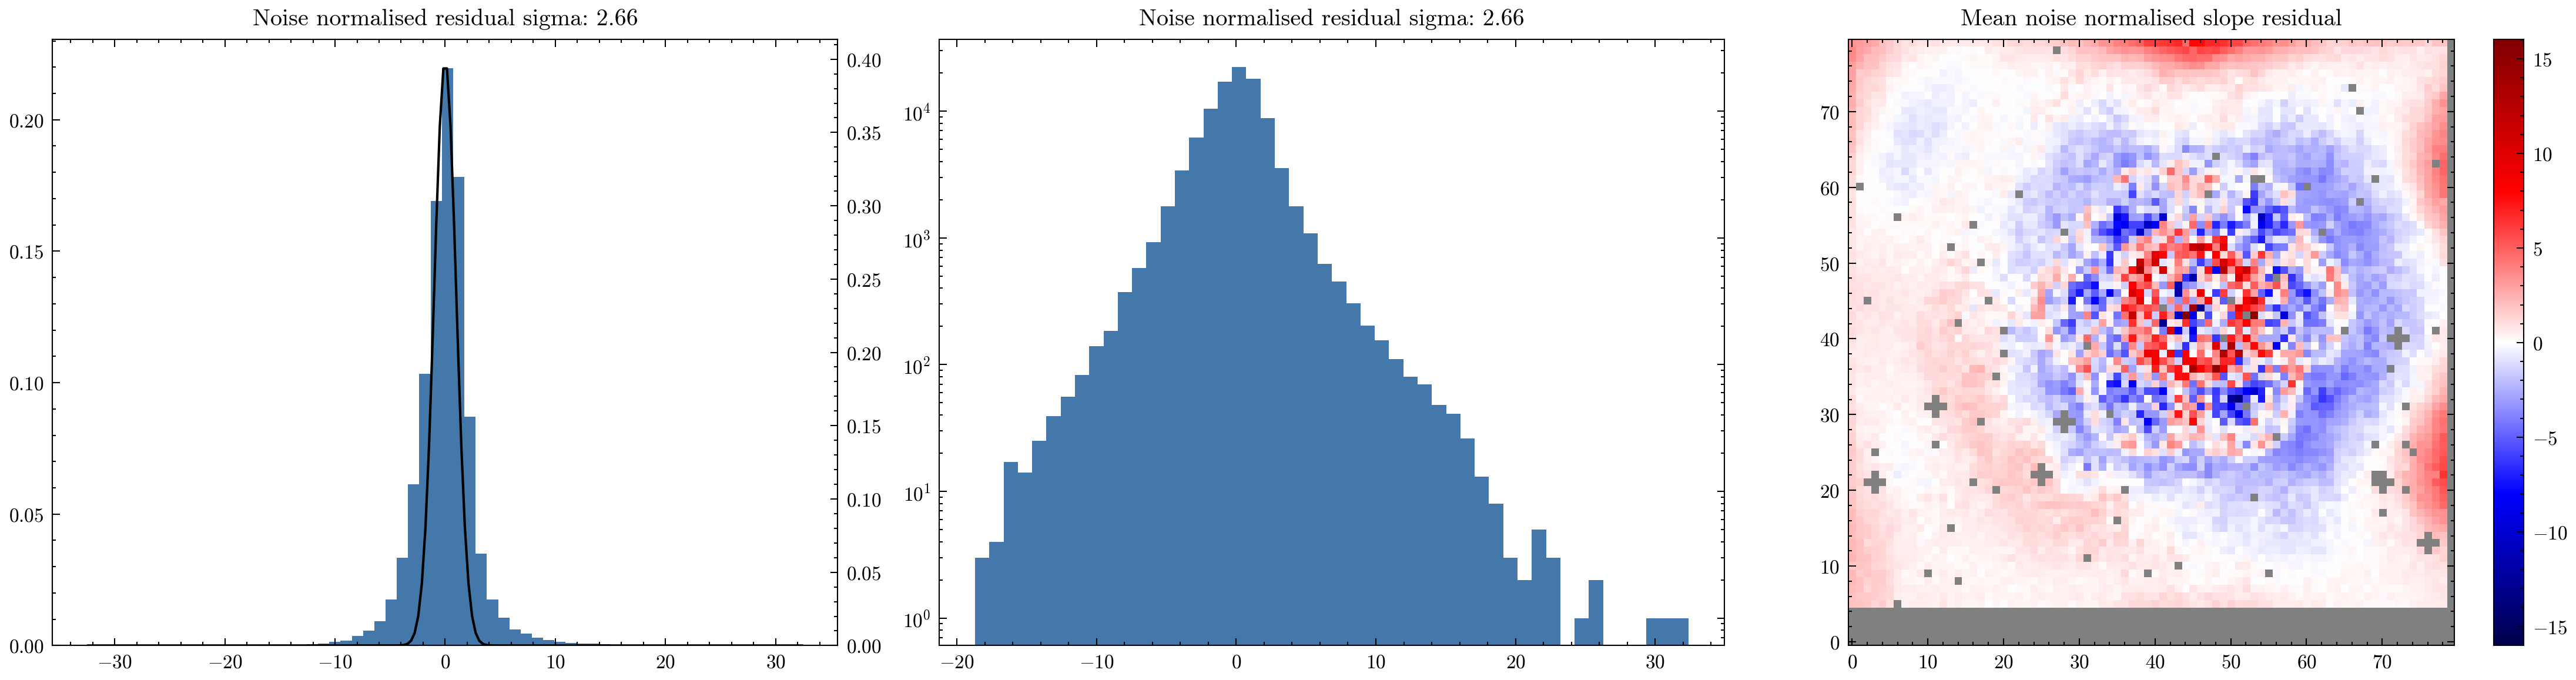

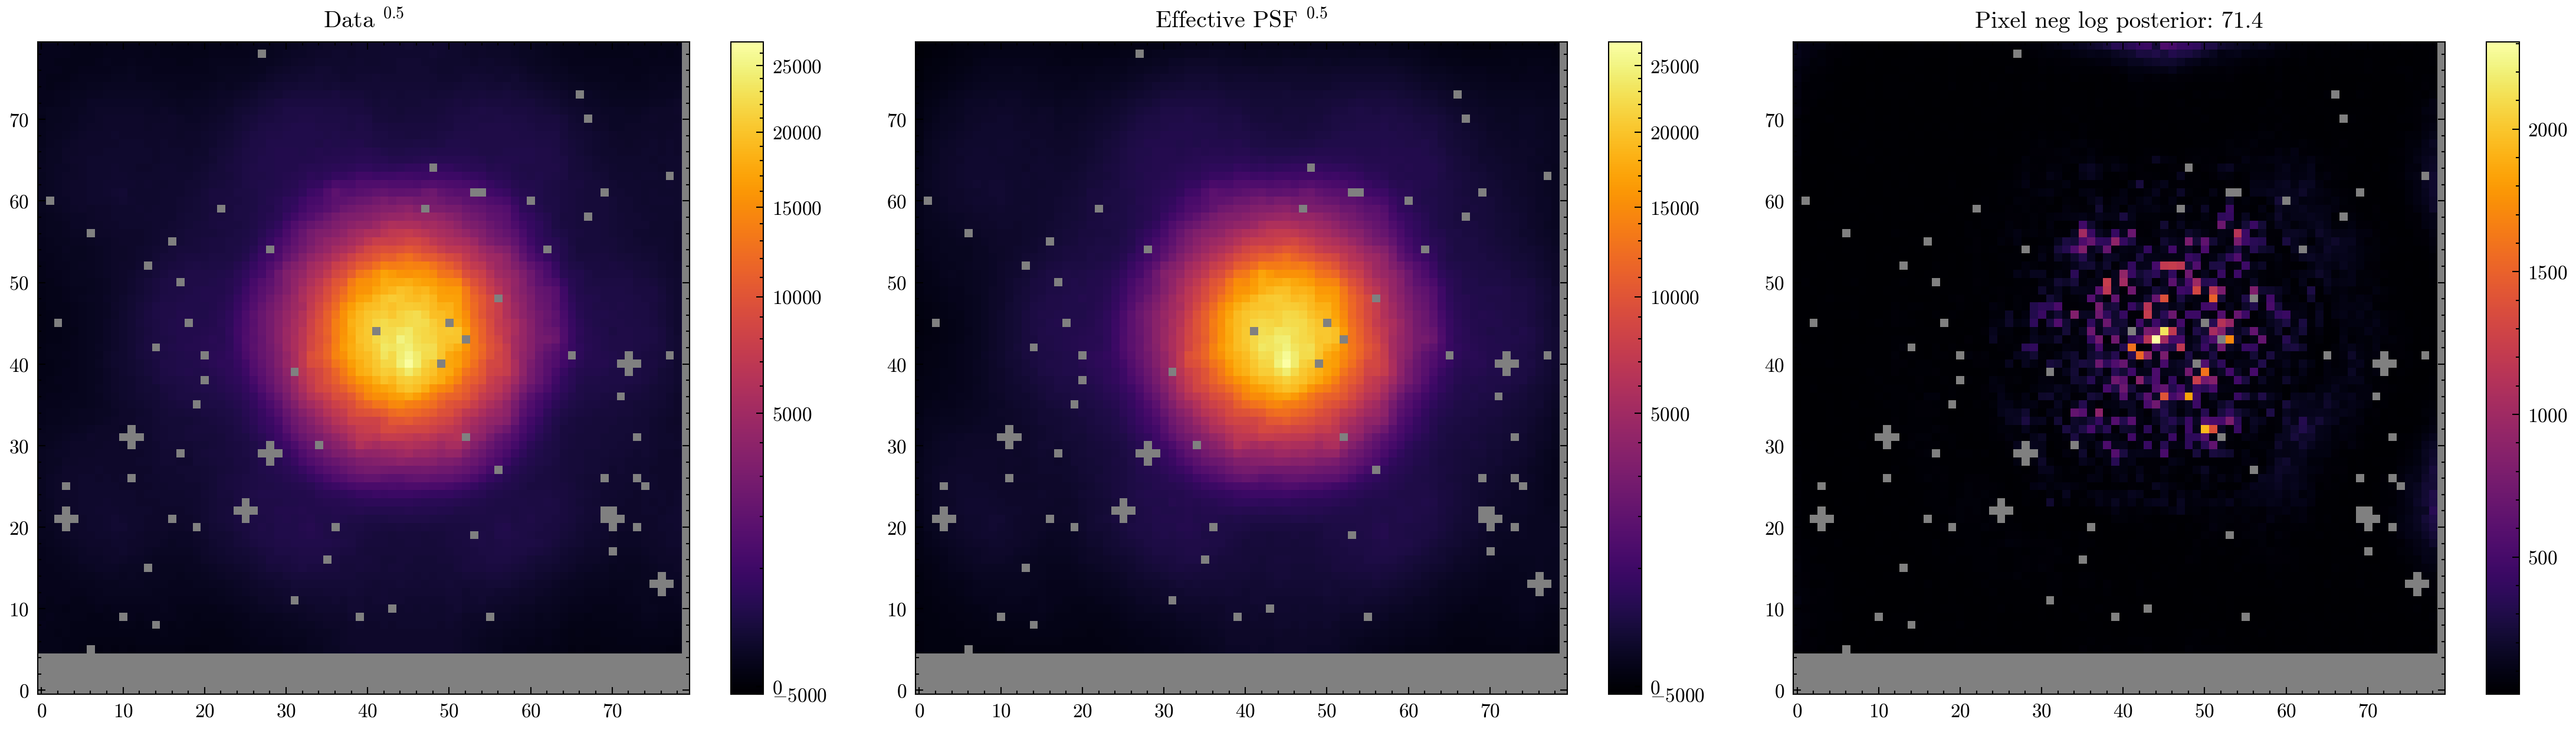

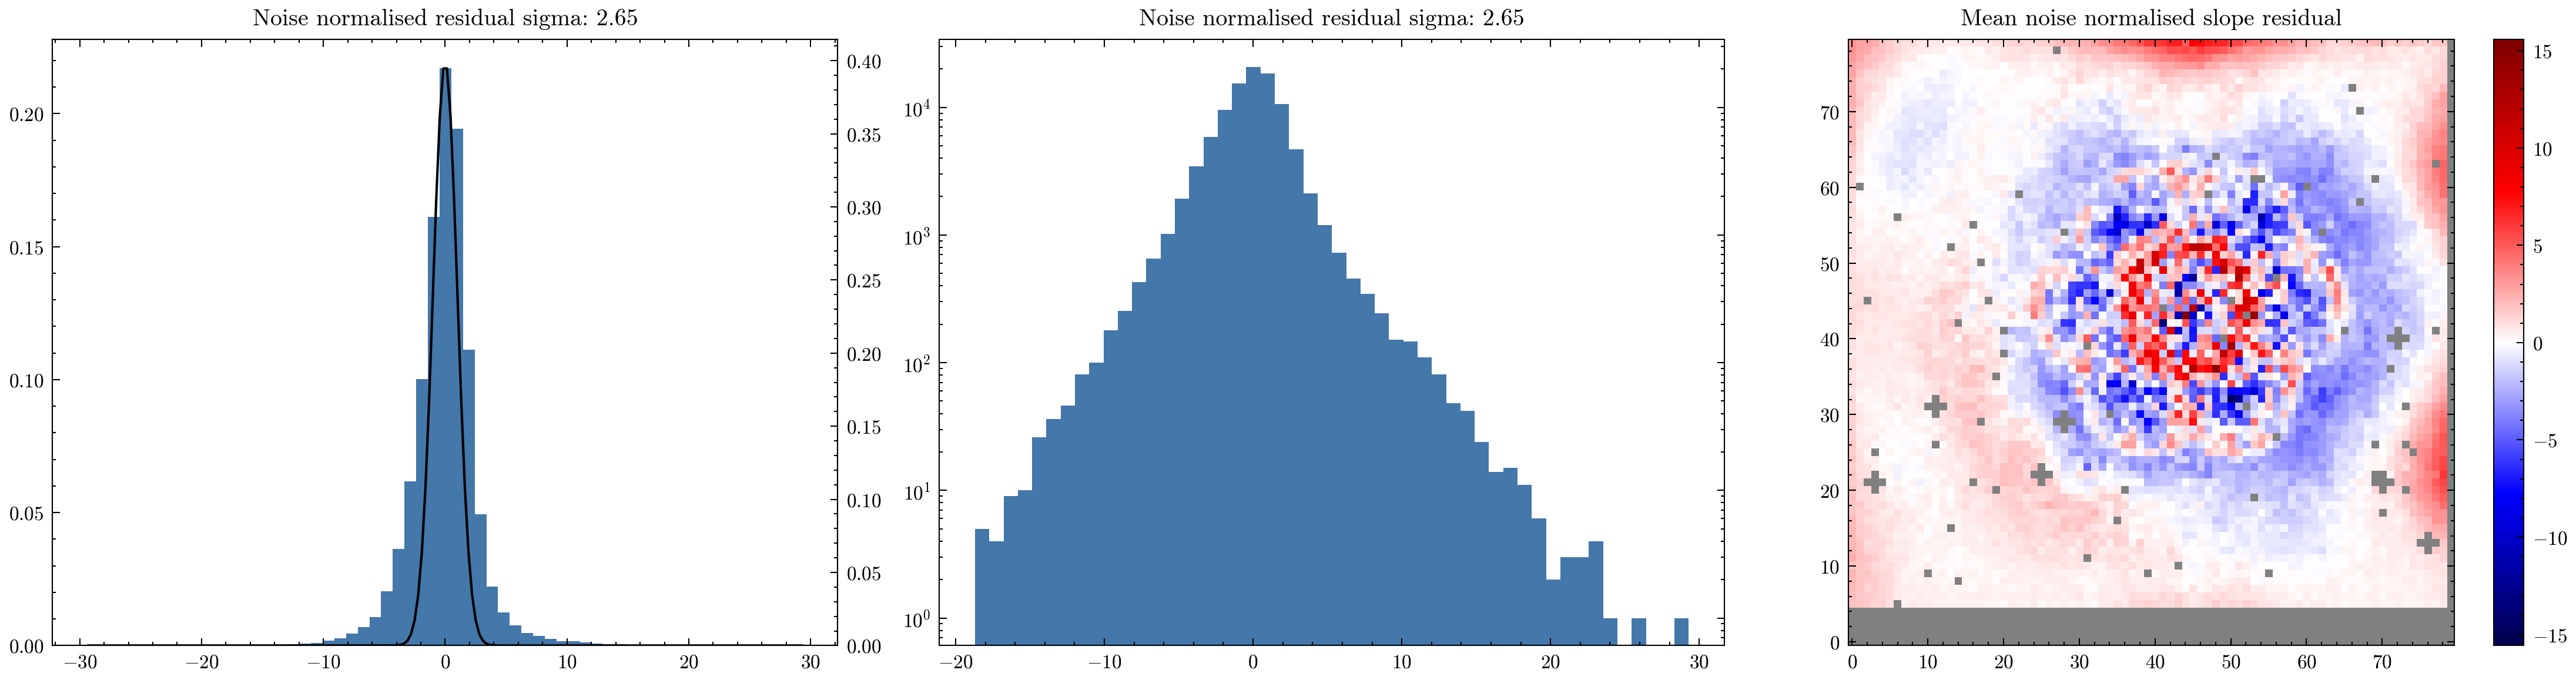

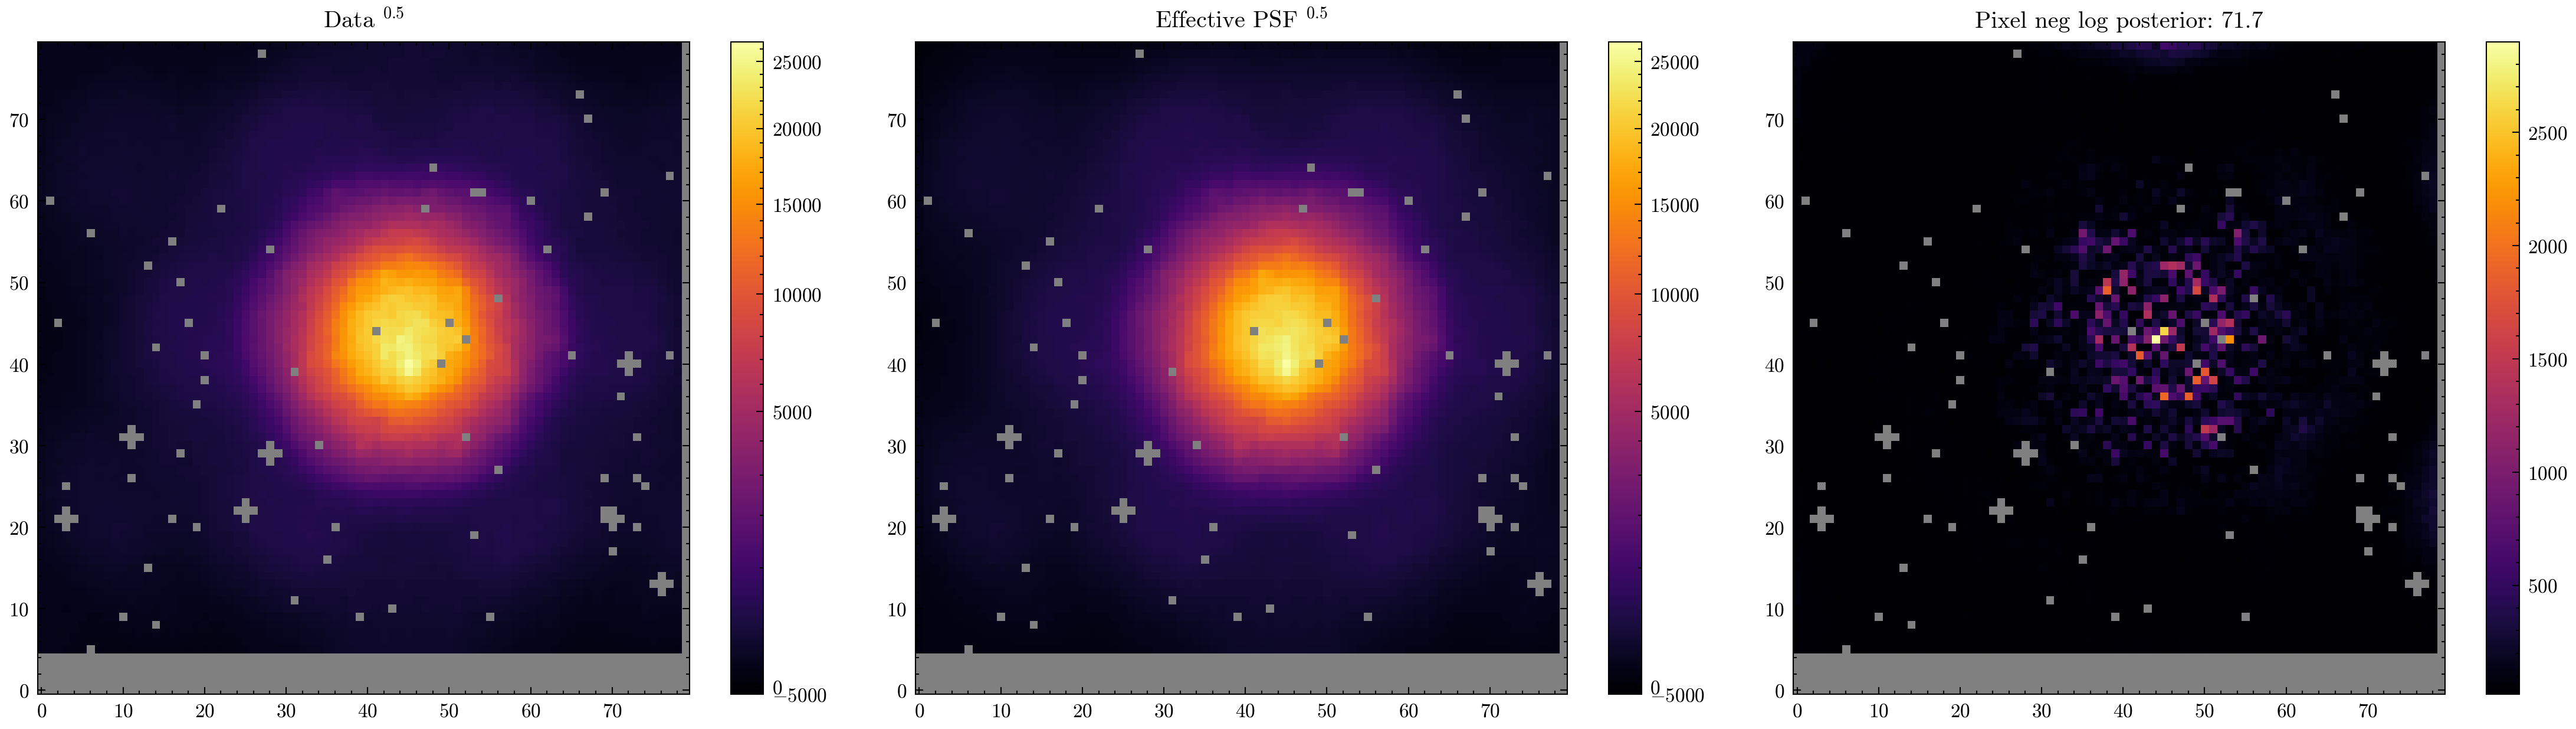

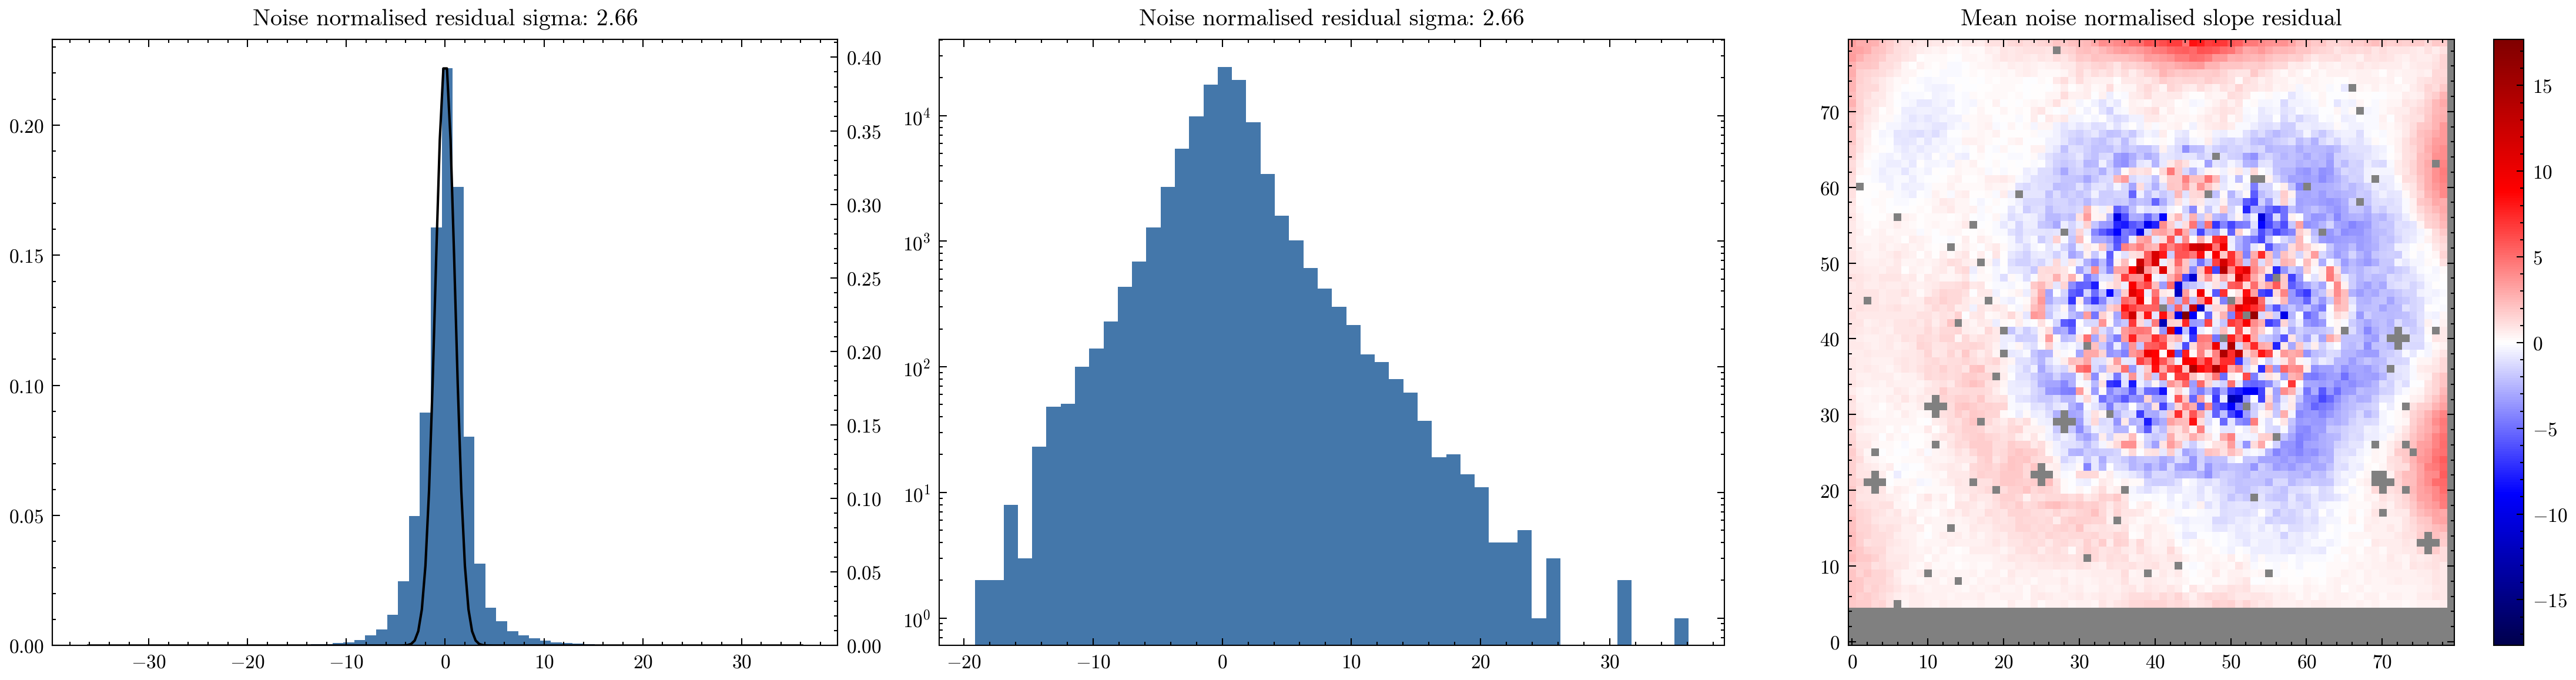

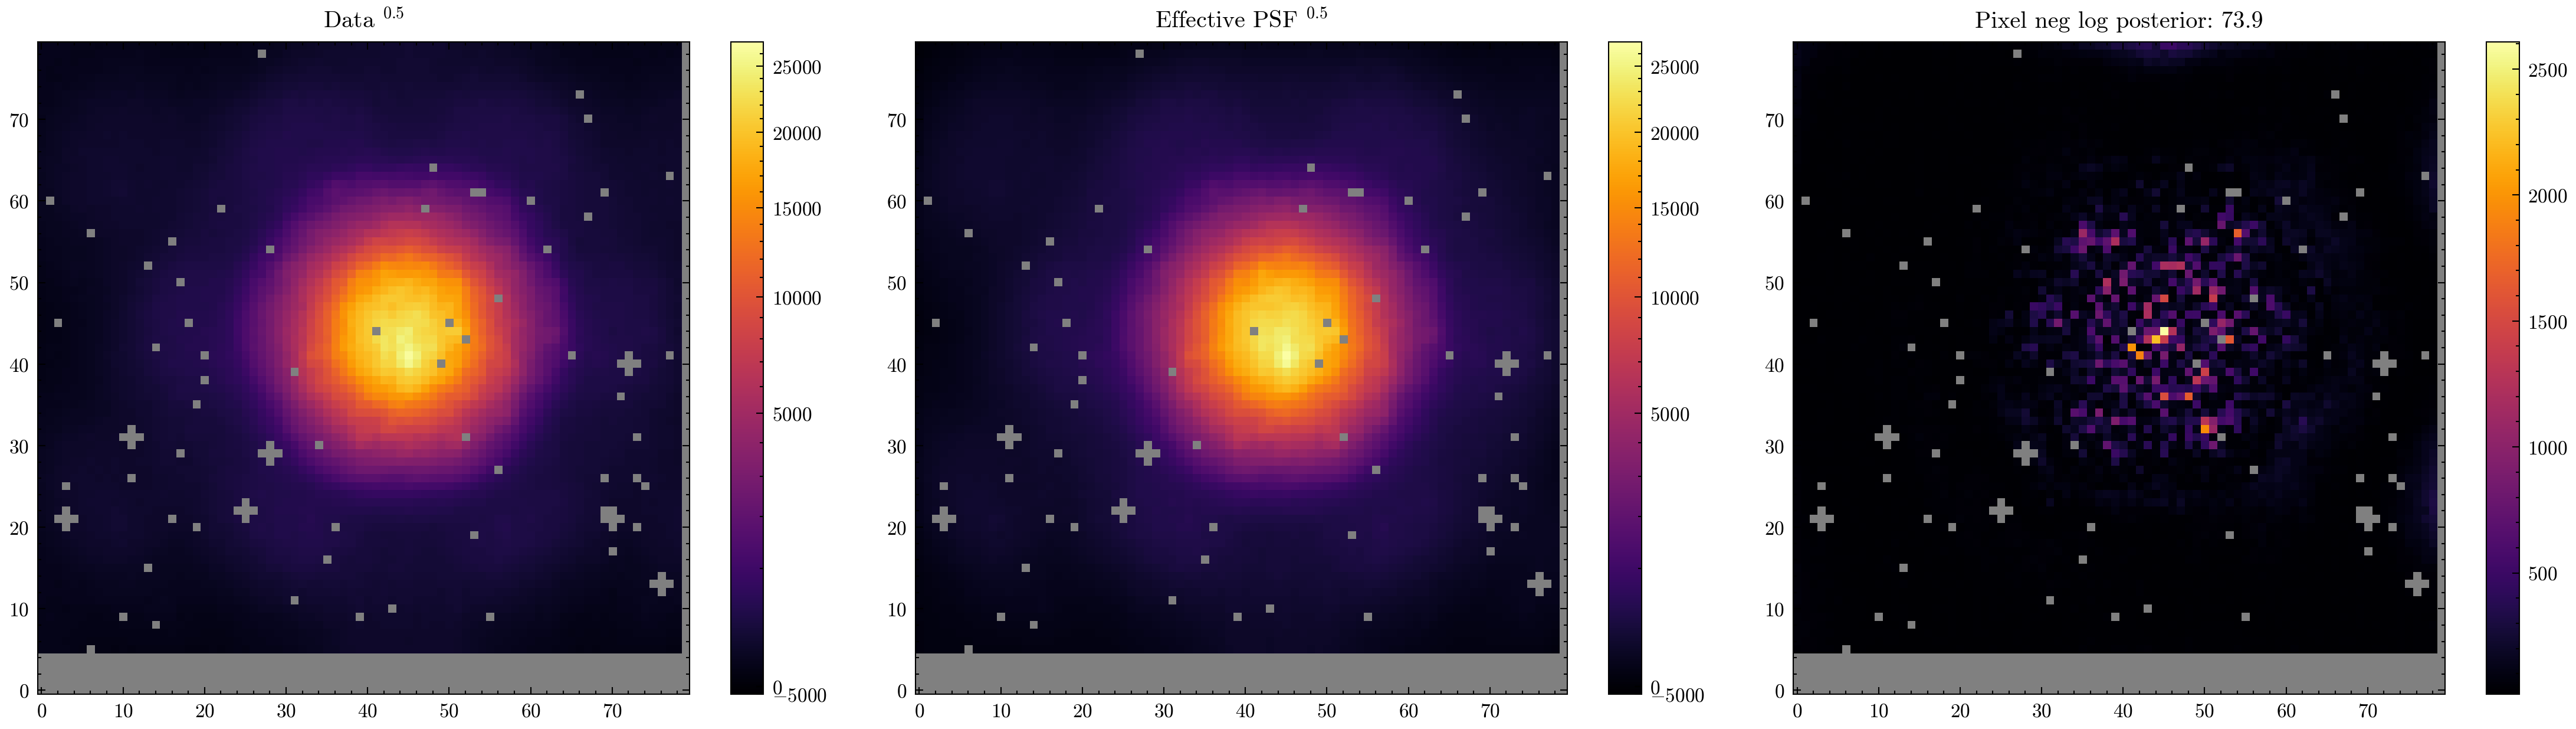

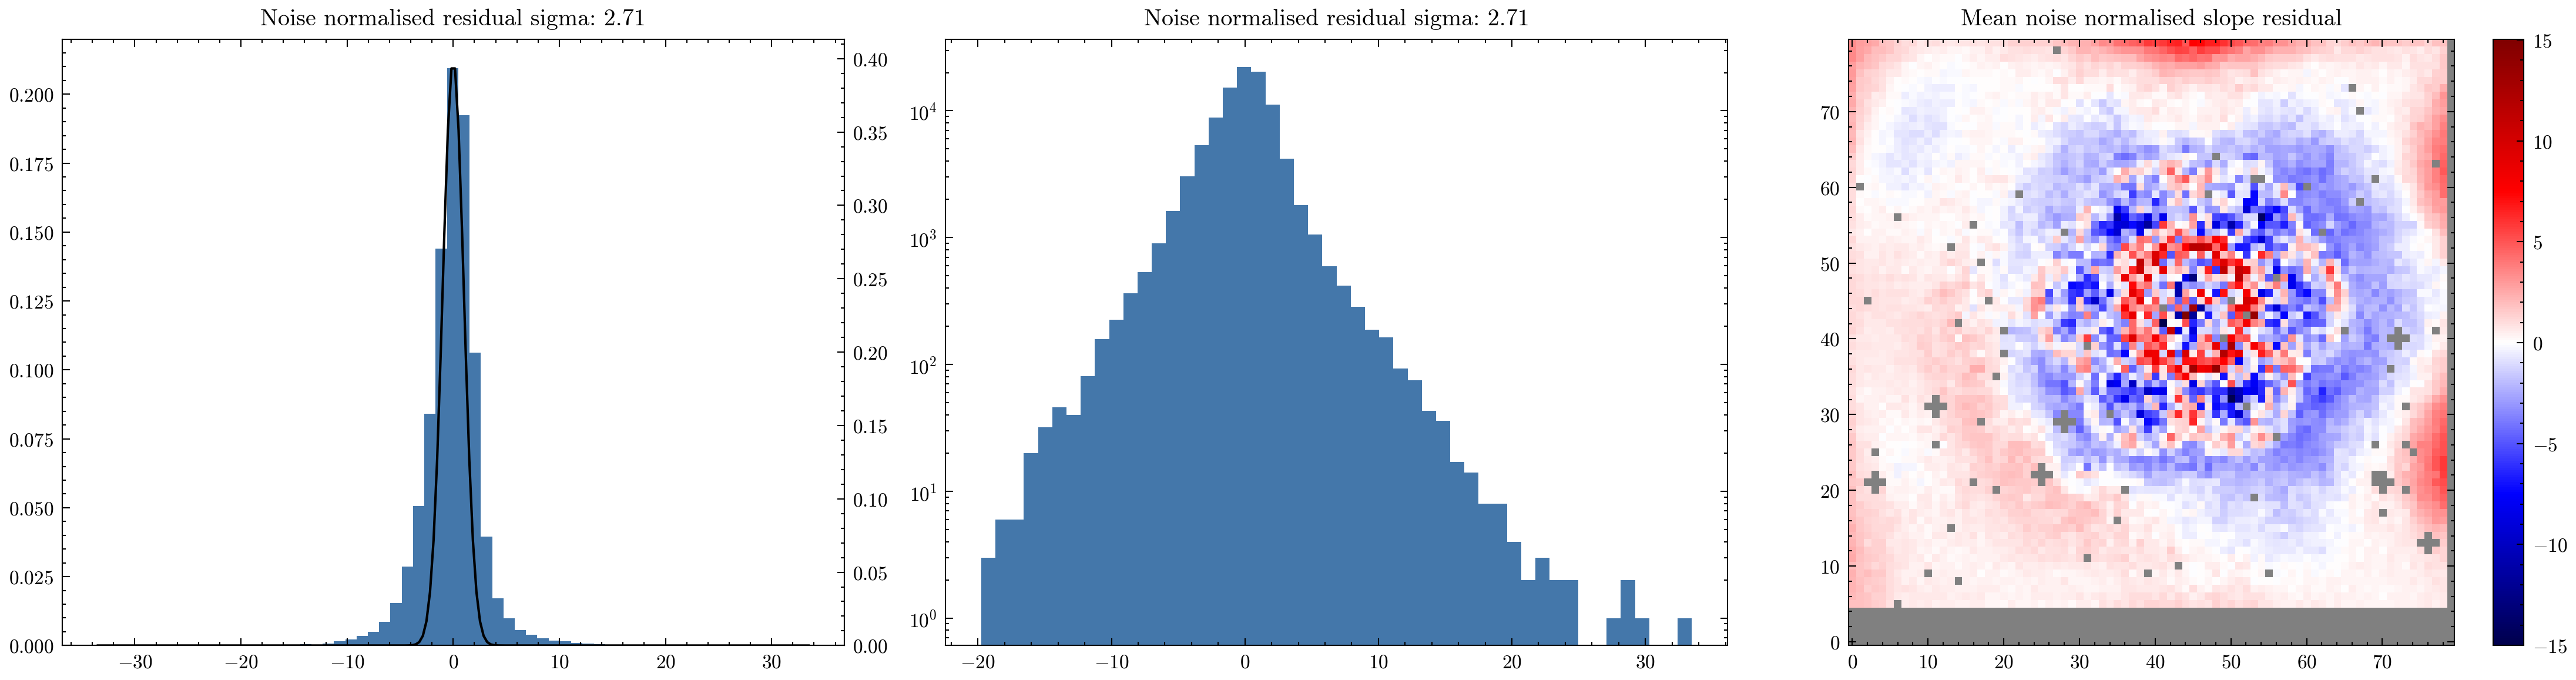

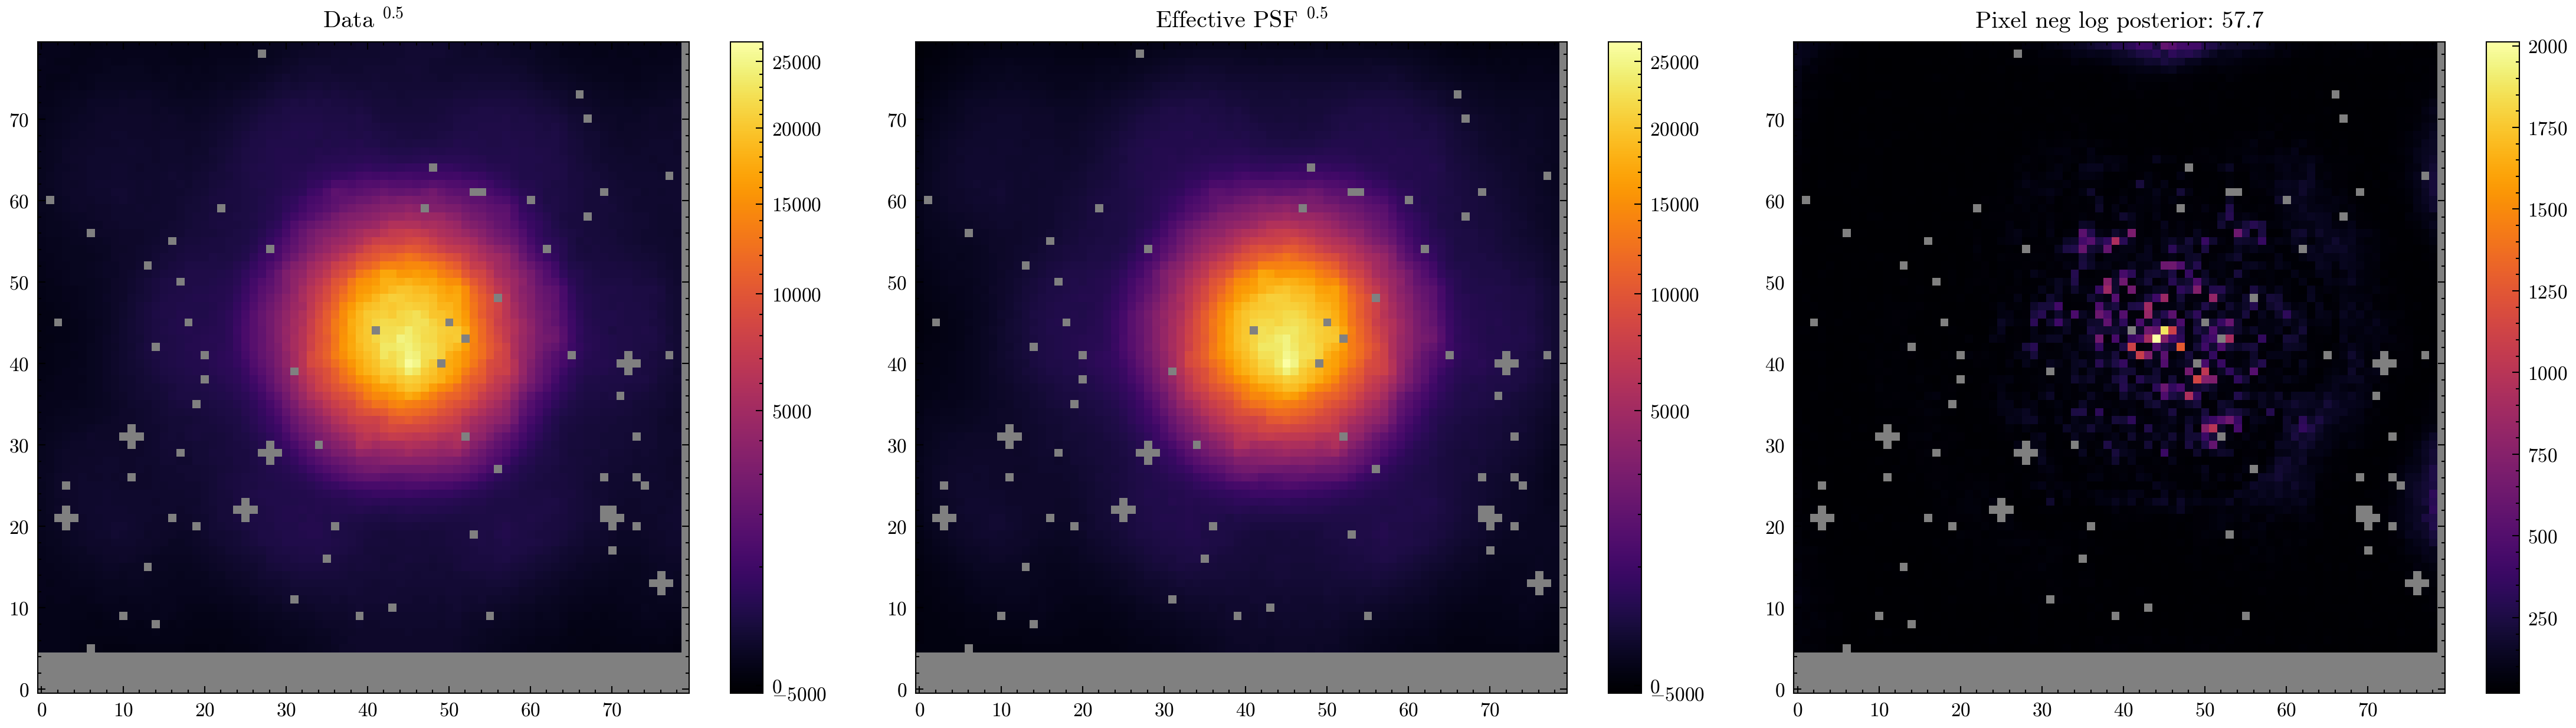

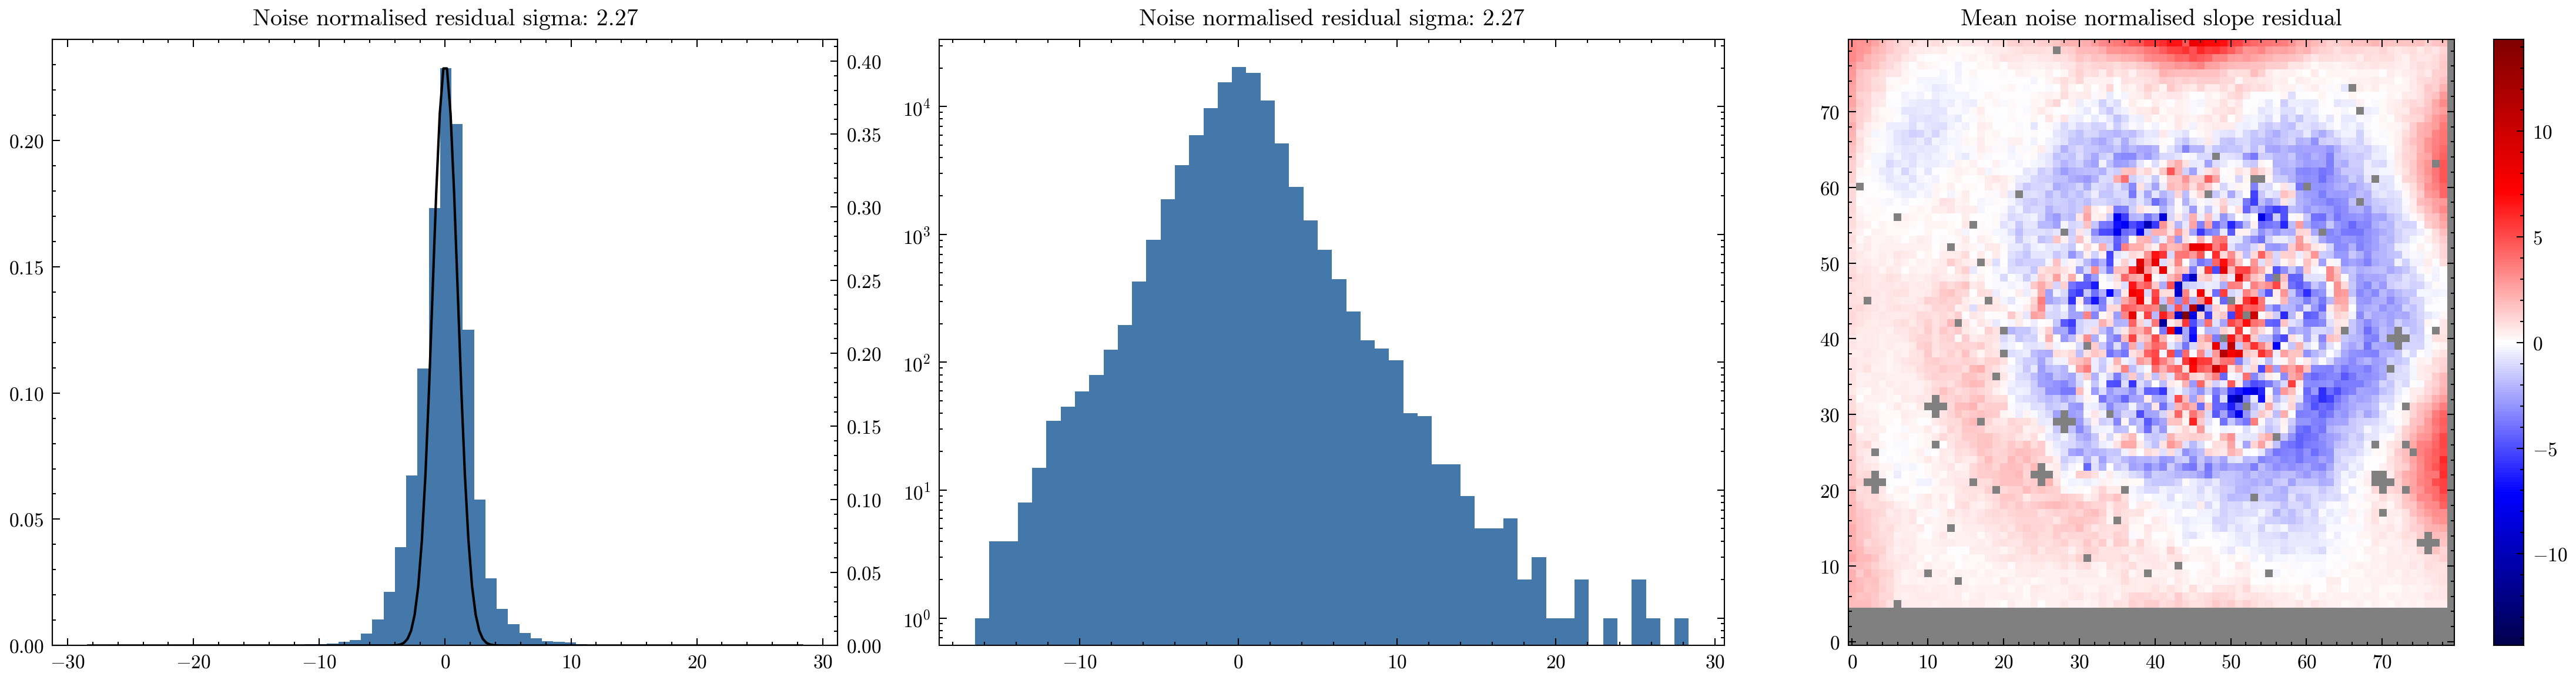

In [13]:
amigo.plotting.plot_losses(losses, start=int(len(losses)*0.75))
amigo.plotting.plot(histories)

for exp in exposures:
    amigo.plotting.summarise_fit(
        exp,
        model,
        # test_model,
        residuals=True,
        histograms=True,
        # flat_field=True,
        # up_the_ramp=True,
        # up_the_ramp_norm=True,
        # full_bias=True,
        # aberrations=True,
    )

# Regularisation Grid

/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/io_outputs/L2_1.3895e-01
/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/io_outputs/TV_1.0000e+00
/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/io_outputs/TV_1.0000e-03
/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/io_outputs/L2_1.3895e+02
/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/io_outputs/QV_1.0000e-03
/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/io_outputs/ME_1.3895e+02
/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/io_outputs/ME_1.3895e-01
/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/io_outputs/QV_1.0000e+00
/Users/mcha5804/Library/CloudStorage/OneDrive-Th